# Charge, Polarity, and Isoelectric point

In [3]:
import re
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
dfs = []
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    proteome_df['proteome'] = proteome
    dfs.append(proteome_df)
df = pd.concat(dfs)

In [5]:
df.describe()

,seq_len,domain_count,max_pae,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,iupred_auc,repeat_6mers,non_repeat_6mers,...,non_repeat_6mers_100,iupred_plddt_spearman,repeat_6mers_2000,non_repeat_6mers_2000,aa_distr_js,freq_pos_charge,freq_neg_charge,freq_polar,freq_non_polar,IEP
count,545555.000000,545555.00000,542051.000000,545555.000000,545555.000000,545555.000000,545555.000000,522125.000000,514622.000000,514622.000000,...,514622.000000,513491.000000,514622.000000,514622.000000,514622.000000,514622.000000,514622.000000,514622.000000,514622.000000,514622.000000
mean,458.873356,1.11808,30.845778,33.727809,75.312362,79.094267,0.354822,125.969805,0.515753,0.000657,...,0.019857,-0.311983,0.755625,0.976791,0.160911,0.139624,0.112231,0.503103,0.245042,7.336256
std,880.781186,12.27124,1.455963,11.363737,14.949144,18.772187,0.291004,147.224706,4.485592,0.048485,...,0.394819,0.317159,5.020129,3.640865,0.064054,0.039520,0.038881,0.073258,0.056422,1.882249
min,16.000000,0.00000,6.000000,1.390000,23.077300,22.170000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.987435,0.000000,0.000000,0.030443,0.000000,0.000000,0.000000,0.000000,4.050000
25%,186.000000,0.00000,30.900000,25.620000,64.928350,64.540000,0.112200,38.063900,0.000000,0.000000,...,0.000000,-0.564031,0.000000,0.000000,0.114615,0.116600,0.089500,0.458700,0.211100,5.693900
50%,333.000000,0.00000,31.300000,31.180000,77.976200,87.315000,0.272000,80.049100,0.000000,0.000000,...,0.000000,-0.345583,0.000000,0.000000,0.147983,0.137300,0.112800,0.501500,0.241200,6.948100
75%,538.000000,1.00000,31.400000,38.590000,87.562600,93.995000,0.552100,156.520200,0.000000,0.000000,...,0.000000,-0.103957,0.000000,1.000000,0.193001,0.158900,0.133700,0.546000,0.274000,9.007700
max,32200.000000,285.00000,31.700000,97.030000,98.724100,98.860000,1.000000,2730.699900,342.000000,11.000000,...,83.000000,0.918797,386.000000,673.000000,0.713420,0.952400,0.888900,1.000000,0.941200,12.000000


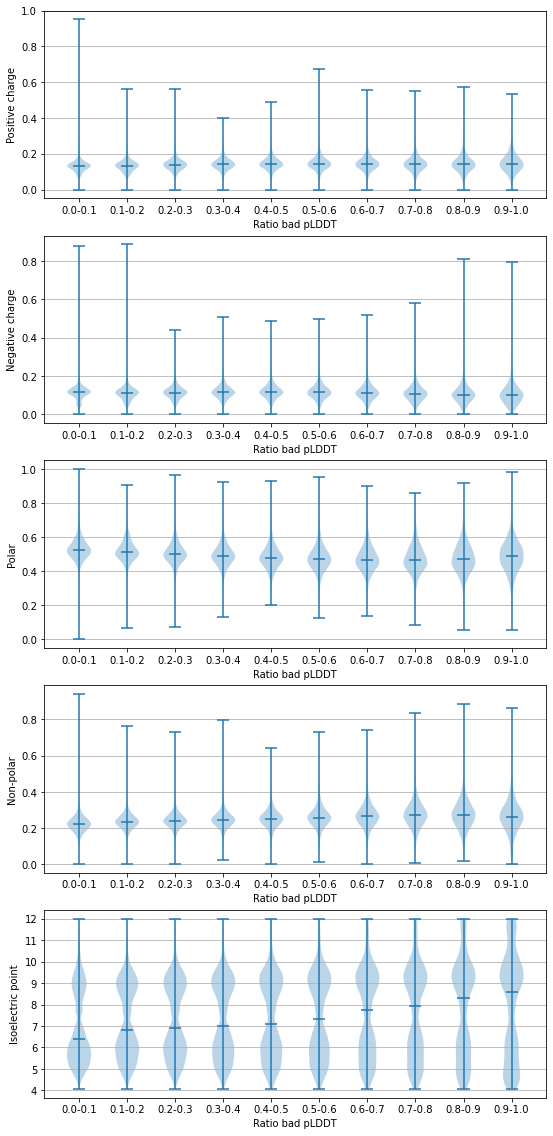

In [14]:
%matplotlib inline
fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(nrows=5, figsize=(9, 20))

def violin_plot(ax, prop, title, bucket_step_size=0.1, decimals=1):
    xprop = 'ratio_bad_plddt'
    df_without_na = df.dropna(subset=[prop])
    buckets_indices = np.arange(np.floor(df_without_na[xprop].min()), df_without_na[xprop].max(), bucket_step_size)
    buckets = [df_without_na[df_without_na[xprop].between(i, i + bucket_step_size, inclusive='left')] for i in buckets_indices]
    labels = [f'{np.round(i, decimals=decimals)}-{np.round(i + bucket_step_size, decimals=decimals)}' for i in buckets_indices]
    ax.violinplot(dataset = [bucket[prop].values for bucket in buckets], showmedians=True)
    ax.yaxis.grid(True)
    ax.set_xlabel('Ratio bad pLDDT')
    ax.set_ylabel(title)
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)

violin_plot(ax1, 'freq_pos_charge', 'Positive charge')
violin_plot(ax2, 'freq_neg_charge', 'Negative charge')
violin_plot(ax3, 'freq_polar', 'Polar')
violin_plot(ax4, 'freq_non_polar', 'Non-polar')
violin_plot(ax5, 'IEP', 'Isoelectric point')

plt.show()

In [6]:
from scipy.stats import spearmanr

df_with_IEP = df.dropna(subset=['IEP'])
rho, p = spearmanr(df_with_IEP['ratio_bad_plddt'], df_with_IEP['IEP'])
print(f'Spearman rank correlation (IEP): {"{0:.4f}".format(rho)}')

Spearman rank correlation (IEP): 0.1459


In [13]:
from sklearn.feature_selection import mutual_info_regression

mutual_info_regression(df_with_IEP['IEP'].values.reshape(-1, 1), df_with_IEP['ratio_bad_plddt'])

array([0.06422177])

In [16]:
df_no_na = df_with_IEP.dropna(subset=['IEP', 'aa_distr_js', 'repeat_6mers_2000', 'iupred_auc'])
mutual_info_regression(df_no_na[['IEP', 'aa_distr_js', 'repeat_6mers_2000', 'iupred_auc']], df_no_na['ratio_bad_plddt'])

array([0.06410789, 0.10483021, 0.04667051, 0.11697099])